<a href="https://colab.research.google.com/github/RyanSVargas/Quant-Finance-Research/blob/main/Quant_Model_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This creates a folder named 'Quant_Trading' in your session
!mkdir Quant_Trading

In [2]:
import yfinance as yf
import pandas as pd

# 1. Download the data
# We use auto_adjust=True to make sure we get a simple 'Close' column
df = yf.download("AAPL", start="2024-01-01", end="2025-12-20", auto_adjust=True)

# 2. THE CRITICAL FIX: Flatten the multi-layered headers if they exist
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

# 3. Double-check: Print the column names to be 100% sure 'Close' is there
print("Current Columns:", df.columns.tolist())
df.head()

[*********************100%***********************]  1 of 1 completed

Current Columns: ['Close', 'High', 'Low', 'Open', 'Volume']


Price,Close,High,Low,Open,Volume
Date,,,,,
2024-01-02,183.903244,186.677052,182.169616,185.399112,82488700
2024-01-03,182.526215,184.140970,181.713879,182.496496,58414500
2024-01-04,180.208145,181.377098,179.187783,180.445890,71983600
2024-01-05,179.484955,181.050175,178.484409,180.287390,62379700
2024-01-08,183.823975,183.863609,179.801961,180.386437,59144500


In [3]:
# Calculate the Moving Averages
df['SMA20'] = df['Close'].rolling(window=20).mean()
df['SMA50'] = df['Close'].rolling(window=50).mean()

# Logic: Buy (1) if SMA20 is higher than SMA50, otherwise Stay Out (0)
df['Signal'] = (df['SMA20'] > df['SMA50']).astype(int)

# Preview the results
df[['Close', 'SMA20', 'SMA50', 'Signal']].tail()

Price,Close,SMA20,SMA50,Signal
Date,,,,
2025-12-15,274.109985,276.384000,268.050757,1
2025-12-16,274.609985,276.741499,268.414128,1
2025-12-17,271.839996,276.961499,268.726296,1
2025-12-18,272.190002,277.142999,269.013894,1
2025-12-19,273.670013,277.514000,269.411415,1


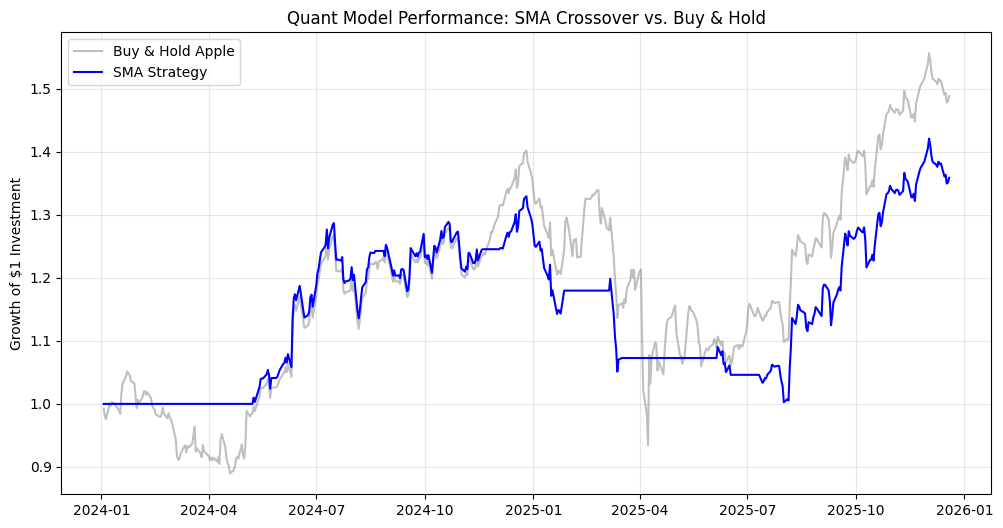

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# ... rest of your code ...

# 1. Calculate Daily Log Returns
# Formula: ln(Price_t / Price_{t-1})
df['Market_Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))

# 2. Calculate Strategy Returns
# We shift the signal by 1 day because we can only trade on the NEXT day's open
df['Strategy_Log_Return'] = df['Market_Log_Return'] * df['Signal'].shift(1)

# 3. Calculate Cumulative Returns (Exponentiate the sum of logs)
df['Cumulative_Market'] = df['Market_Log_Return'].cumsum().apply(np.exp)
df['Cumulative_Strategy'] = df['Strategy_Log_Return'].cumsum().apply(np.exp)

# 4. Plot the Performance
plt.figure(figsize=(12,6))
plt.plot(df['Cumulative_Market'], label='Buy & Hold Apple', color='gray', alpha=0.5)
plt.plot(df['Cumulative_Strategy'], label='SMA Strategy', color='blue')
plt.title("Quant Model Performance: SMA Crossover vs. Buy & Hold")
plt.ylabel("Growth of $1 Investment")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [5]:
# This saves the chart as an image in your new folder
plt.savefig('/content/Quant_Trading/SMA_Backtest_Chart.png')

<Figure size 640x480 with 0 Axes>

In [8]:
import numpy as np

# 1. Calculate the Daily Sharpe Ratio
# We use 'Strategy_Log_Return' which we created in the previous steps
mean_return = df['Strategy_Log_Return'].mean()
std_return = df['Strategy_Log_Return'].std()

# 2. Annualize it (252 trading days in a year)
# Formula: (Mean / Std) * sqrt(252)
annualized_sharpe = (mean_return / std_return) * np.sqrt(252)

print(f"--- RISK METRICS ---")
print(f"Strategy Annualized Sharpe Ratio: {annualized_sharpe:.2f}")

# 3. Calculate Maximum Drawdown (The biggest 'drop' from a peak)
cumulative_rets = df['Strategy_Log_Return'].cumsum().apply(np.exp)
running_max = cumulative_rets.cummax()
drawdown = (cumulative_rets - running_max) / running_max
max_drawdown = drawdown.min()

print(f"Maximum Drawdown: {max_drawdown:.2%}")

--- RISK METRICS ---
Strategy Annualized Sharpe Ratio: 0.86
Maximum Drawdown: -24.58%
